In [2]:
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model


from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from google.colab import drive

In [7]:
#get access to google colab
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [11]:
import pandas as pd


df_train = pd.read_csv("/content/gdrive/MyDrive/train_set.csv")


df_test = pd.read_csv("/content/gdrive/MyDrive/test_set.csv")

df_train.head()

,Historical Period,height,diam,width,depth,num_period,medium_num,classif_num,culture_num
0,Antiquity,7.1,-1.0,10.8,-1.0,4.0,3.046062,2.533376,2.136866
1,Antiquity,-1.0,3.7,-1.0,-1.0,4.0,3.046062,3.998735,4.000000
2,Antiquity,2.9,-1.0,9.2,-1.0,4.0,3.875496,3.993417,3.905965
3,Antiquity,2.7,-1.0,2.2,-1.0,4.0,3.046062,2.533376,3.301802
4,Antiquity,-1.0,-1.0,-1.0,-1.0,4.0,3.119048,2.533376,3.841270


In [12]:
df_train.iloc[20000,:]

Historical Period    Contemporary Era
height                          241.9
diam                             -1.0
width                           117.5
depth                            -1.0
num_period                        1.0
medium_num                   1.728041
classif_num                  2.153191
culture_num                  2.136866
Name: 20000, dtype: object

### Preprocessing

#### Get X and y

In [13]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

periods_train = np.array(df_train["Historical Period"]).reshape(-1, 1)

ohe = OneHotEncoder(sparse=False)
ohe.fit(periods_train)
y_ohe_train = ohe.transform(periods_train)

periods_test = np.array(df_test["Historical Period"]).reshape(-1, 1)
y_ohe_test = ohe.transform(periods_test)
y_ohe_train

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [ ]:
# key: name of the class; item: index of the column in y
#dico_period_ohe = {"Modern Times":3, "Contemporary Era":1, "Antiquity":0, "Middle Ages":2}

In [14]:
import numpy as np
y_train = np.array(df_train["num_period"])
y_train

array([4., 4., 4., ..., 2., 2., 2.])

In [15]:
X_train = np.array(df_train.drop(columns=["Historical Period", "num_period"]))
X_train.shape

(40180, 7)

In [16]:
y_test = np.array(df_test["num_period"])
X_test = np.array(df_test.drop(columns=["Historical Period", "num_period"]))

In [17]:
# keys: initial classes ; values: position of the column in ohe output data
#dico_map_init_ohe = {"1.0":"Contemporary Era", "2.0":"Modern Times", "3.0":"Middle Ages", "4.0":"Antiquity"}
#map_period = {"Antiquity":1., "Contemporary Era": 2., "Middle Ages":3., "Modern Times":4.}
dico_map_ohe = {}

for i,val in enumerate(y_test):
  if val not in dico_map_ohe.keys():
    dico_map_ohe[val] = np.argmax(y_ohe_test[i,:])
  if len(dico_map_ohe)==4:
    break

In [18]:
dico_map_ohe

{1.0: 1, 2.0: 3, 3.0: 2, 4.0: 0}

In [19]:
y_train_ = [dico_map_ohe[target] for target in y_train]
y_test_ = [dico_map_ohe[target] for target in y_test]

#### Rescaling the features

medium_num, culture_num and classif_num are bounded between 1 and 4 by construction (fine).


Let's transform the features related to dimensions: height, width, depth and diam. It doesn't really make sense (from a physical point of view) to normalize them to zero mean and unit variance. Instead, let's rescale them so that they are between 0 and 1:

In [20]:
X_train[0,:]

array([ 7.1       , -1.        , 10.8       , -1.        ,  3.04606152,
        2.53337623,  2.13686557])

In [21]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train[:,:4])
dims_train_minmax = scaler.transform(X_train[:,:4])

In [22]:
# check
print(np.min(dims_train_minmax, axis=0), np.max(dims_train_minmax, axis=0))

[0. 0. 0. 0.] [1. 1. 1. 1.]


In [23]:
X_train[:,:4] = dims_train_minmax
print(X_train[0,:])

[0.00339836 0.         0.00640886 0.         3.04606152 2.53337623
 2.13686557]


In [24]:
# apply the same transformation on testing set
dims_test_minmax = scaler.transform(X_test[:,:4])
X_test[:,:4] = dims_test_minmax
X_test[0,:]

array([0.        , 0.00655793, 0.        , 0.        , 2.93310463,
       3.05988515, 2.96666667])

### Deep learning architectures

MLP

In [25]:
#@title Imports libraries
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from glob import glob
import os
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [47]:
def mlp_depending_num_hidden_layers(n_hidden_layers, num_classes):
  mlp_baseline = Sequential()
  for i in range(n_hidden_layers):
    mlp_baseline.add(Dense(10, activation='relu'))
  
  mlp_baseline.add(Dense(num_classes, activation = 'softmax'))
  mlp_baseline.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])
  mlp_baseline.fit(X_train, y_ohe_train, epochs=10, verbose=False)
  score = mlp_baseline.evaluate(X_test, y_ohe_test, verbose=False)
  return score[1]



In [49]:
import random
random.seed(42)

num_hidden_layers : 1
num_hidden_layers : 2
num_hidden_layers : 3
num_hidden_layers : 4
num_hidden_layers : 5
num_hidden_layers : 6
num_hidden_layers : 7
num_hidden_layers : 8
num_hidden_layers : 9
num_hidden_layers : 10


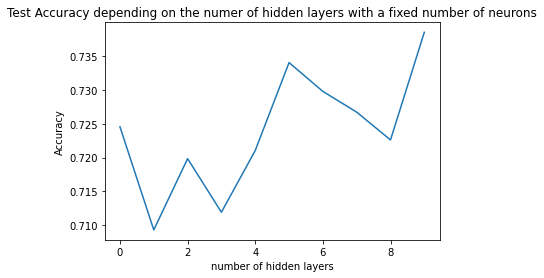

In [50]:
accuracy = []
for i in range(1,11):
  acc = mlp_depending_num_hidden_layers(n_hidden_layers=i, num_classes=4)
  accuracy.append(acc)
  print(f'num_hidden_layers : {i}')

plt.plot(accuracy)
plt.xlabel("number of hidden layers")
plt.ylabel("Accuracy")
plt.title("Test Accuracy depending on the numer of hidden layers with a fixed number of neurons")
plt.show()

In each hidden layers, we consider 10 neurons.
We see clearly that the accuracy on the test set is better with a number of hidden layer of 10. We don't have a global evolution of the performance with the the number of hidden layer

Let's take the best model, and build a confusion matrix

In [51]:
num_classes = 4

best_model = Sequential()
for i in range(1,11):
  best_model.add(Dense(10, activation='relu'))

best_model.add(Dense(num_classes, activation = 'softmax'))


best_model.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

best_model.fit(X_train, y_ohe_train, epochs=10)

Epoch 1/10
1256/1256 [==============================] - 4s 2ms/step - loss: 0.8758 - accuracy: 0.6076
Epoch 2/10
1256/1256 [==============================] - 3s 2ms/step - loss: 0.6956 - accuracy: 0.7035
Epoch 3/10
1256/1256 [==============================] - 3s 2ms/step - loss: 0.6820 - accuracy: 0.7148
Epoch 4/10
1256/1256 [==============================] - 3s 2ms/step - loss: 0.6758 - accuracy: 0.7188
Epoch 5/10
1256/1256 [==============================] - 3s 2ms/step - loss: 0.6728 - accuracy: 0.7201
Epoch 6/10
1256/1256 [==============================] - 3s 2ms/step - loss: 0.6732 - accuracy: 0.7203
Epoch 7/10
1256/1256 [==============================] - 3s 2ms/step - loss: 0.6708 - accuracy: 0.7200
Epoch 8/10
1256/1256 [==============================] - 3s 2ms/step - loss: 0.6699 - accuracy: 0.7196
Epoch 9/10
1256/1256 [==============================] - 3s 2ms/step - loss: 0.6657 - accuracy: 0.7226
Epoch 10/10
1256/1256 [==============================] - 3s 2ms/step - loss: 0.663

In [52]:
def plot_confusion_matrix(model, X_test, y_test, model_name=""):
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns

    #preds = model.predict(X_test)
    preds = np.argmax(model.predict(X_test), axis=1) # adapt to softmax
    conf_mat = confusion_matrix(y_test, preds)
    plt.figure(figsize=(8,8))
    sns.heatmap(conf_mat, cmap="Blues",
    annot=True,
    )
    plt.title("Confusion matrix of {}".format(model_name))
    plt.xlabel("Predicted class")
    plt.ylabel("True class")
    plt.show()

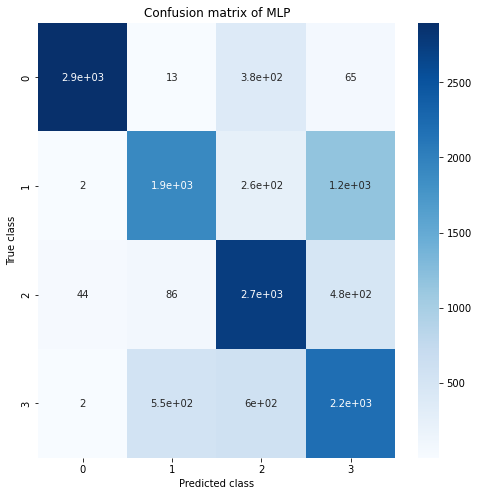

In [53]:
plot_confusion_matrix(best_model, X_test, y_test=y_test_, model_name="MLP")